# Rasterizing a GeoPackage File Larger Than Memory

This notebook demonstrates how to rasterize a Corine Land Cover vector land use GeoPackage (GPKG) file using a meshgrid. It shows how to produce an xarray dataset containing the fraction of each land use category within each mesh. The primary challenge addressed here is handling a file larger than available memory by employing a batch approach.

This notebook relies on two key functions: `covering_mesh` and `generator_geopandas`.

1. `covering_mesh`: This function generates a regular grid covering the bounding box of a GeoDataFrame, allowing for spatial partitioning of the study area. It takes a GeoDataFrame representing geographic features, a cell size parameter defining the size of grid cells, and optional parameters for rounding grid coordinates and returning indices.

2. `generator_geopandas`: This function generates batches of GeoDataFrames from a GeoPackage file, enabling efficient handling of large datasets that may exceed available memory. It accepts parameters such as the path to the GeoPackage file, the batch size specifying the number of rows to read per batch, and an optional maximum row limit. By yielding GeoDataFrames in batches, this function allows for iterative processing of large spatial datasets, mitigating memory constraints and enabling scalable analysis.

The CLC data was downloaded from https://land.copernicus.eu/en/products/corine-land-cover/clc2018.

In [1]:
from collections import defaultdict
from random import choices

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from geometry_utils import covering_mesh, generator_geopandas
from matplotlib.colors import LogNorm
from tqdm.auto import tqdm

In [2]:
path_clc_gpkg = "data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"
path_france = "data/FRA_adm.zip"

A regular meshgrid covering the area of interest (in this case, France) is computed using `covering_mesh`:

In [3]:
CRS = 2154
CELL_SIZE = 7.5e3
CELL_AREA = CELL_SIZE**2

In [4]:
france = gpd.read_file(path_france).to_crs(CRS)
x, y, grid = covering_mesh(france, cell_size=CELL_SIZE, return_xy=True, return_indices=True)
nx, ny = len(x), len(y)

In [5]:
grid.sample(3)

,index,geometry,iy,ix
9587,9587,"POLYGON ((385649.998 6507294.143, 385649.998 6...",62,39
8438,8438,"POLYGON ((1008149.998 6447294.143, 1008149.998...",54,122
10179,10179,"POLYGON ((205649.998 6537294.143, 205649.998 6...",66,15


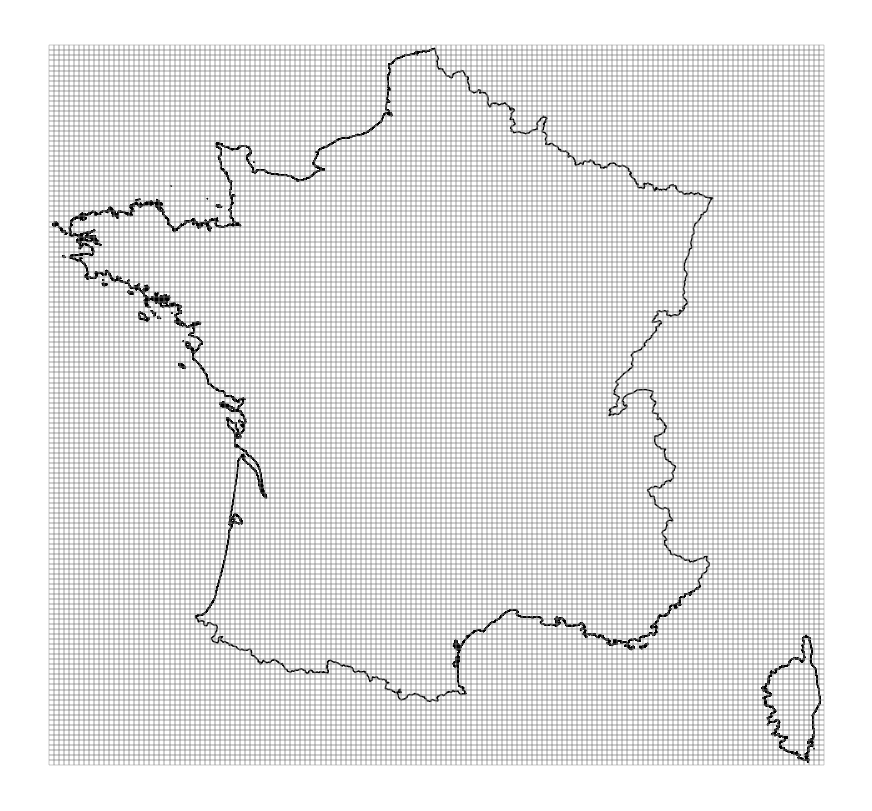

In [6]:
france.plot(fc='none', figsize=(11, 11))
grid.plot(ax=plt.gca(), fc='none', ec='grey', lw=0.3)
plt.gca().axis('off')
plt.show()

This is the heart of the rasterization process. The data is analyzed in batches of equal sizes, with each batch intersected with the meshgrid. As processing progresses, the `ret` dictionary is updated whenever a new land use category appears.

In [7]:
ret = defaultdict(lambda: np.zeros((ny, nx)))
for batch_gdf in tqdm(generator_geopandas(path=path_clc_gpkg, batch_size=100_000, engine='pyogrio')):
    batch_overlay = gpd.overlay(batch_gdf[['Code_18', 'geometry']].to_crs(CRS), grid)
    batch_overlay['area'] = batch_overlay.geometry.area
    for code, overlay_code in batch_overlay.groupby('Code_18'):
        iy, ix, areas = overlay_code['iy'].values, overlay_code['ix'].values, overlay_code['area'].values
        ret[code][iy, ix] += areas/CELL_AREA
ret = dict(ret)

0it [00:00, ?it/s]

The data is then converted into an xarray Dataset, which can be saved in various formats such as NetCDF. CLC codes are replaced with their nomenclatures to enhance readability.

In [8]:
metadata = pd.read_csv("data/u2018_clc2018_v2020_20u1_geoPackage/Legend/CLC_legend.csv", sep=';')
metadata.set_index('CLC_CODE', inplace=True)
metadata.sample(3)

,GRID_CODE,LABEL3,RGB
CLC_CODE,,,
243,21,"Land principally occupied by agriculture, with...",230-204-077
312,24,Coniferous forest,000-166-000
122,4,Road and rail networks and associated land,204-000-000


In [9]:
ds = xr.Dataset(coords={'x': x, 'y': y})
for code in ret:
    name = metadata.at[int(code), 'LABEL3']
    ds[name] = (('y', 'x'), ret[code])
    ds[name].attrs.update({'code': code})
ds

<xarray.Dataset> Size: 8MB
Dimensions:                                                                                 (
                                                                                             x: 154,
                                                                                             y: 143)
Coordinates:
  * x                                                                                       (x) float64 1kB ...
  * y                                                                                       (y) float64 1kB ...
Data variables: (12/45)
    Continuous urban fabric                                                                 (y, x) float64 176kB ...
    Discontinuous urban fabric                                                              (y, x) float64 176kB ...
    Industrial or commercial units                                                          (y, x) float64 176kB ...
    Road and rail networks and associated land                                              (y, x) float64 176kB ...
    Airports                                                                                (y, x) float64 176kB ...
    Mineral extraction sites                                                                (y, x) float64 176kB ...
    ...                                                                                      ...
    Water bodies                                                                            (y, x) float64 176kB ...
    Coastal lagoons                                                                         (y, x) float64 176kB ...
    Estuaries                                                                               (y, x) float64 176kB ...
    NODATA                                                                                  (y, x) float64 176kB ...
    Intertidal flats                                                                        (y, x) float64 176kB ...
    Sea and ocean                                                                           (y, x) float64 176kB ...

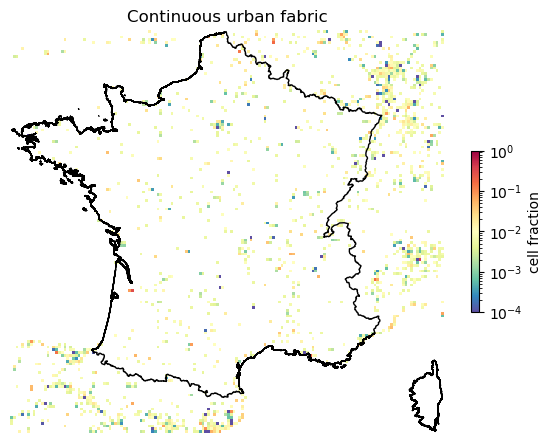

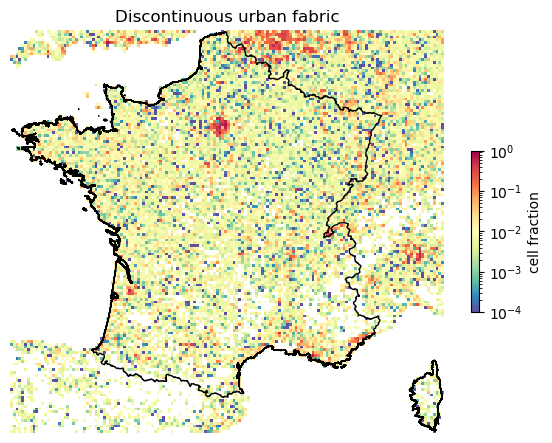

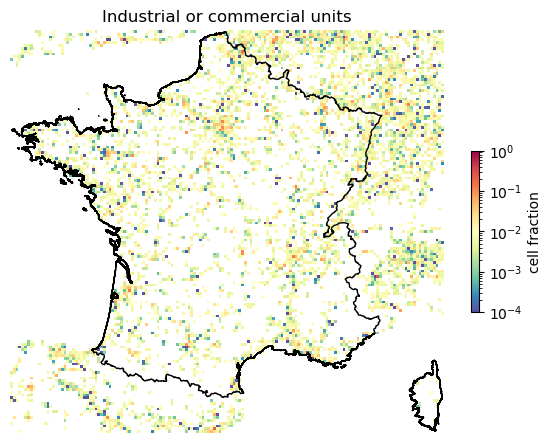

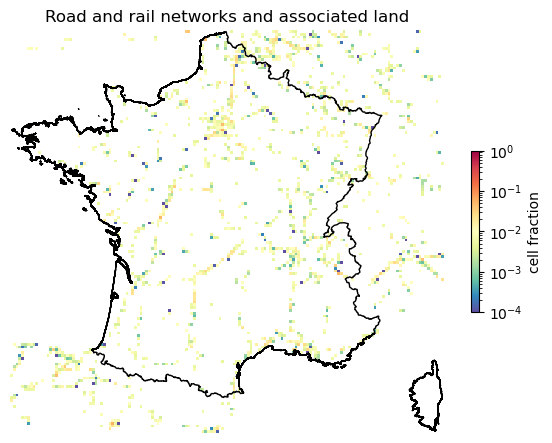

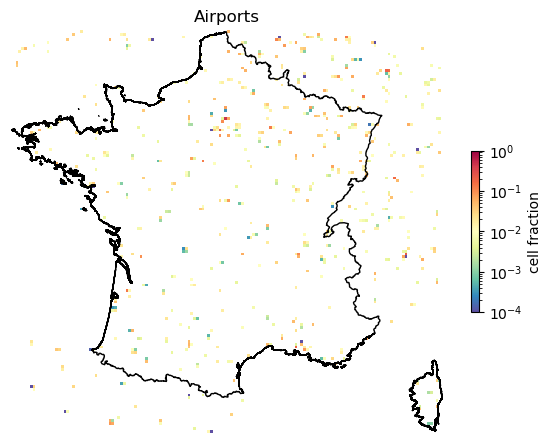

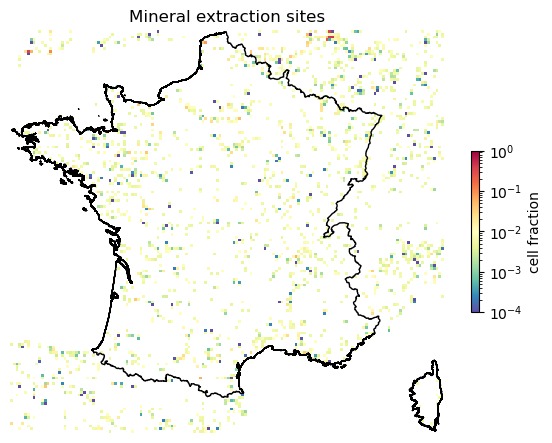

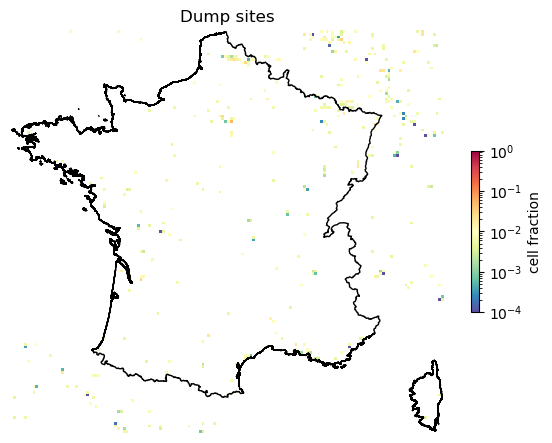

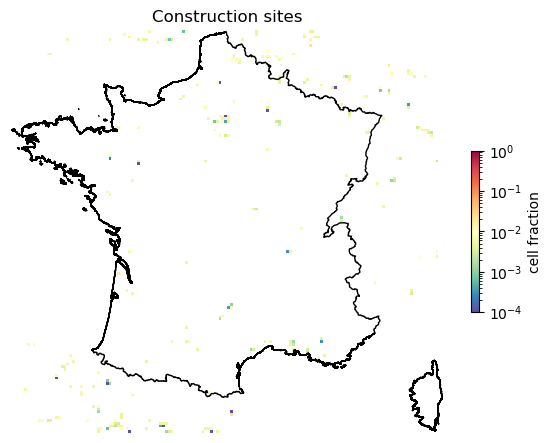

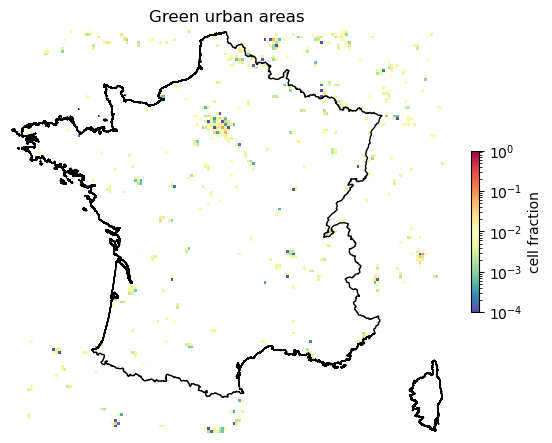

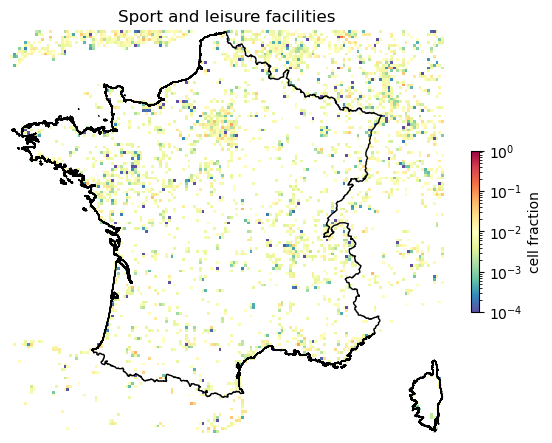

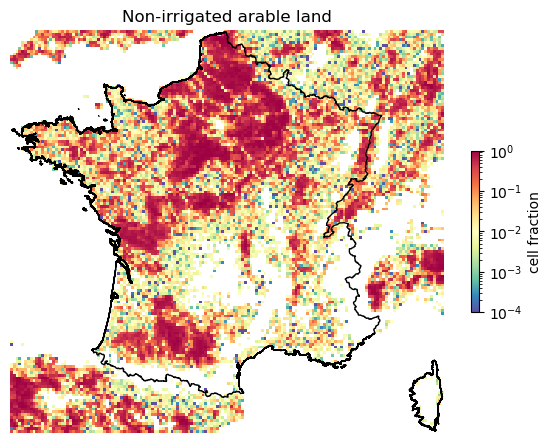

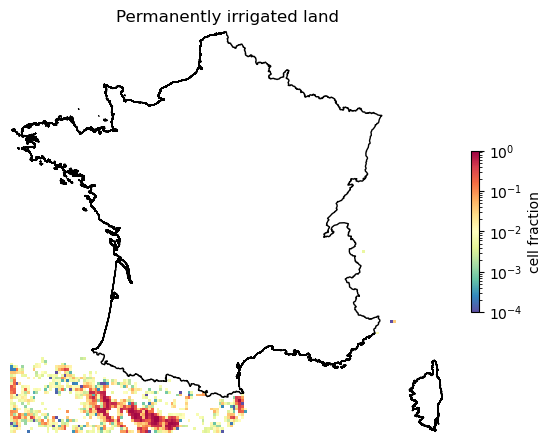

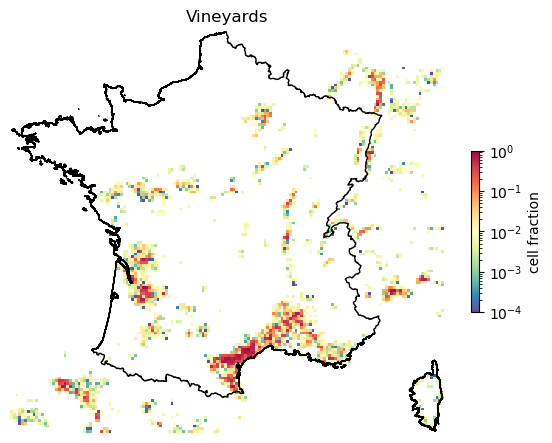

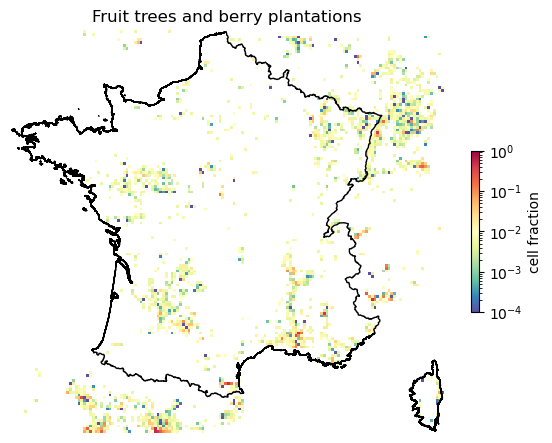

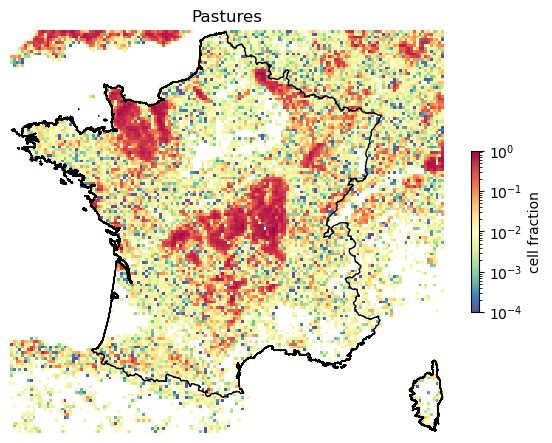

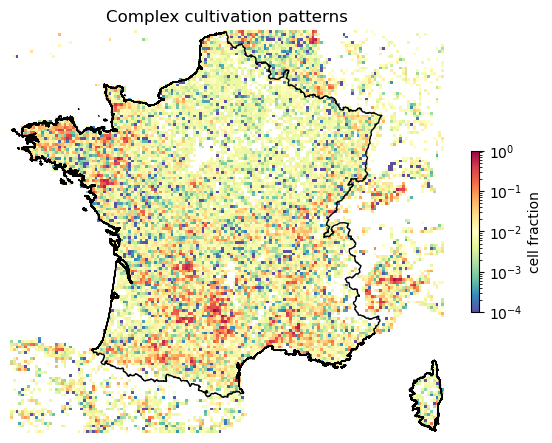

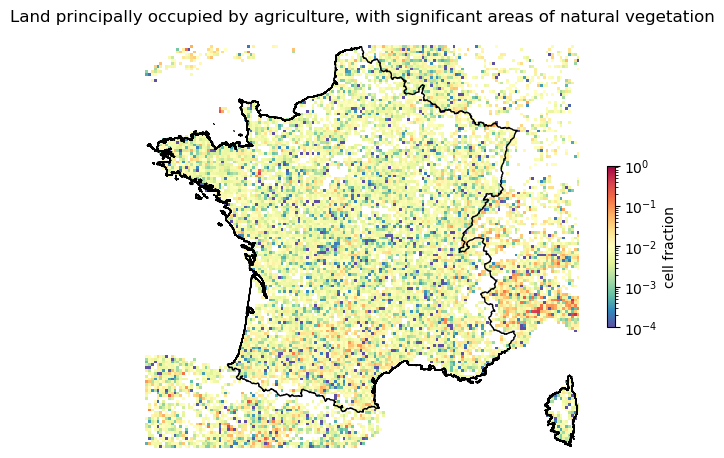

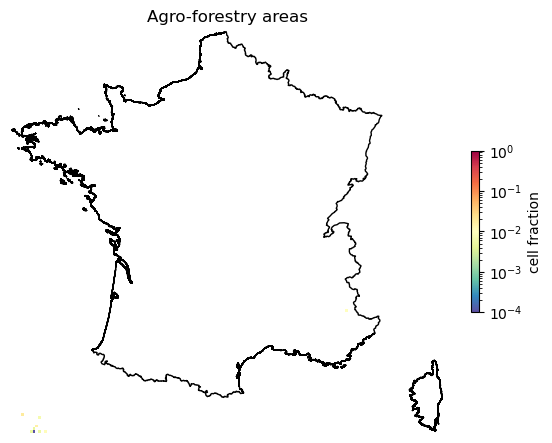

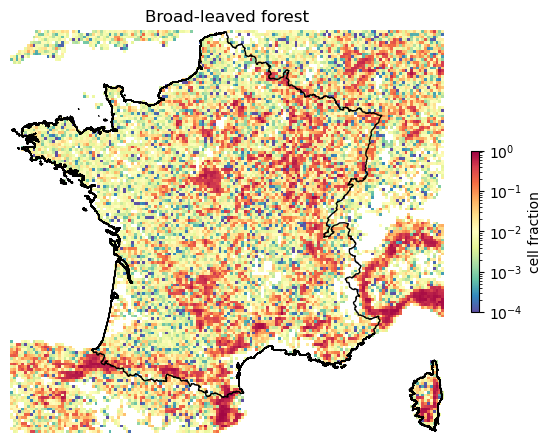

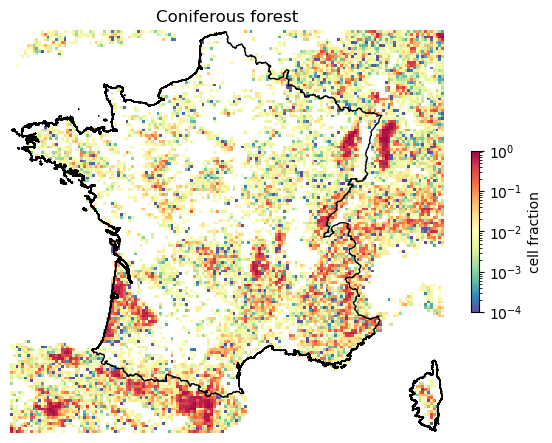

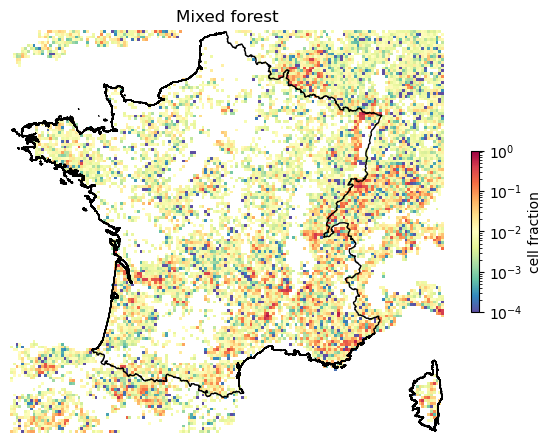

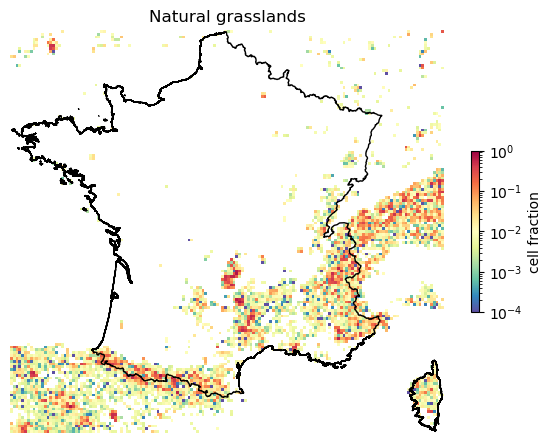

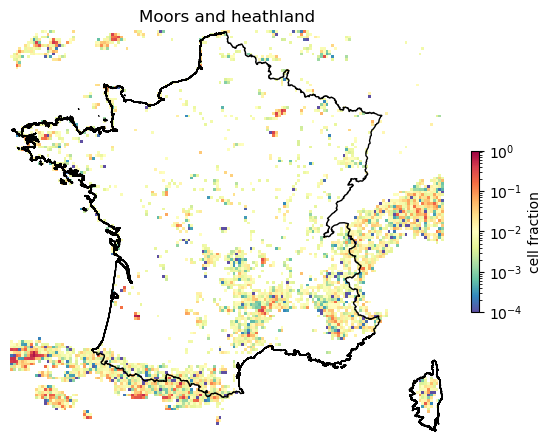

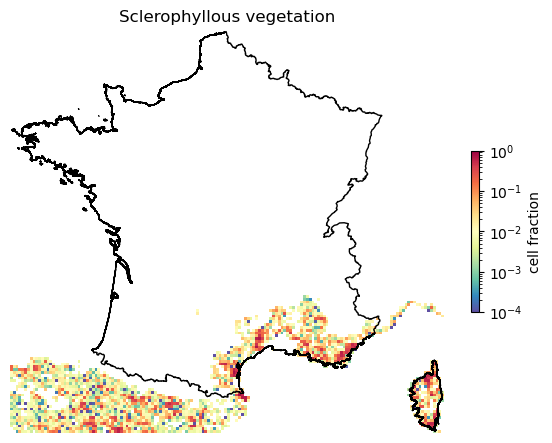

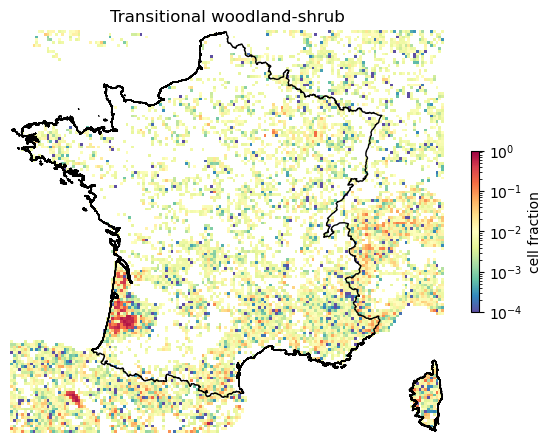

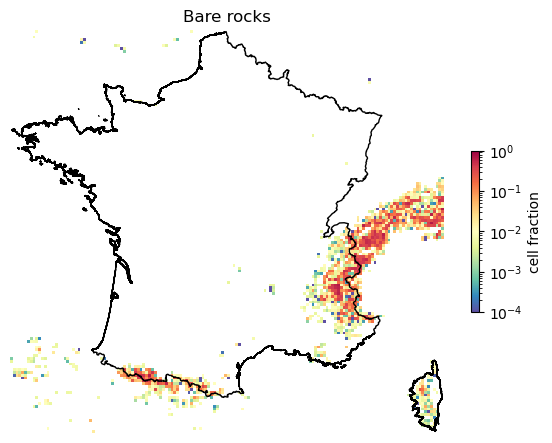

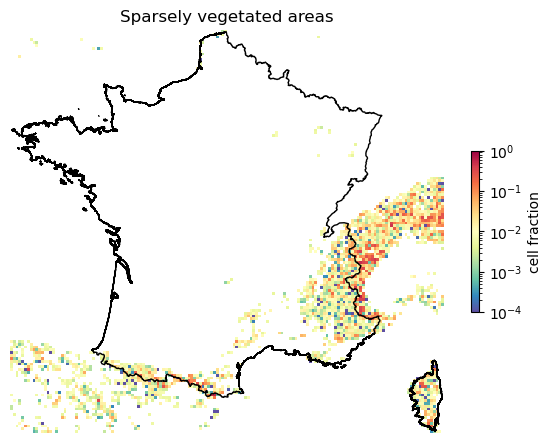

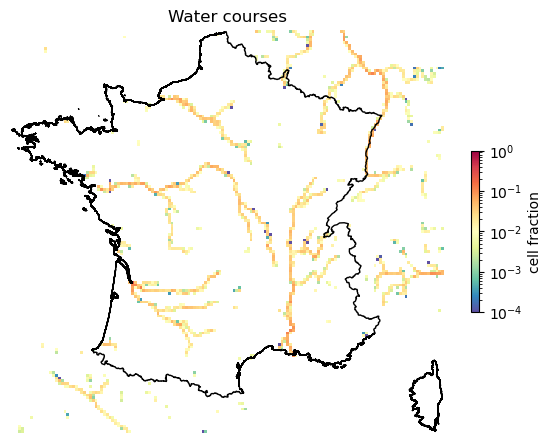

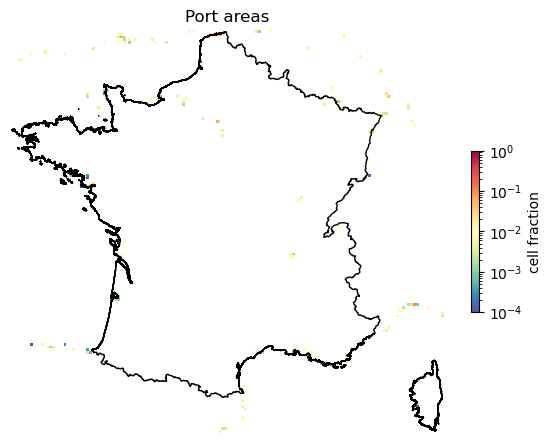

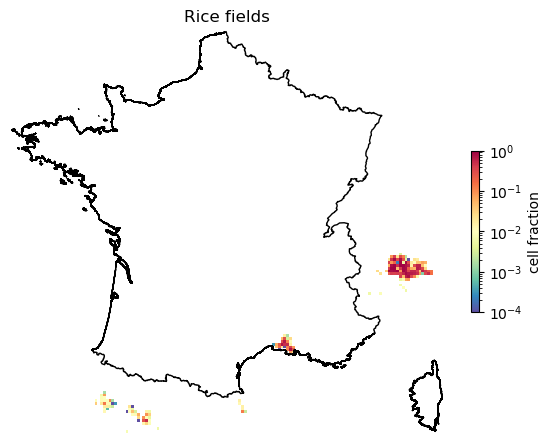

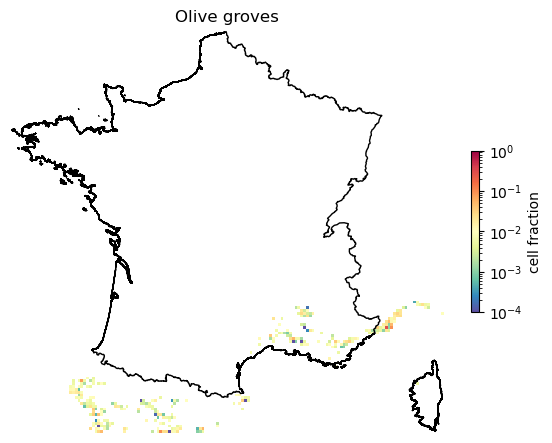

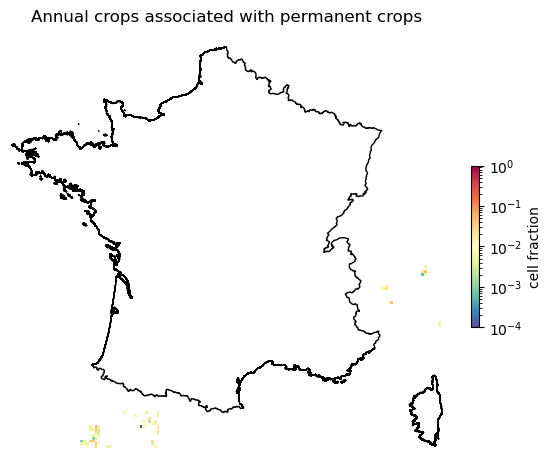

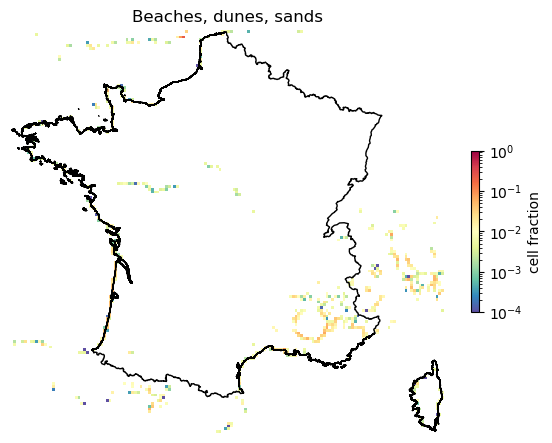

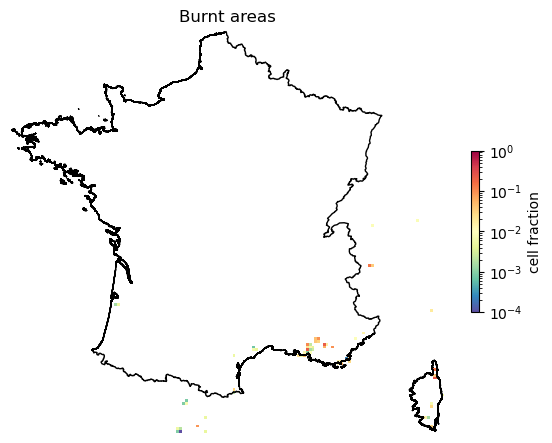

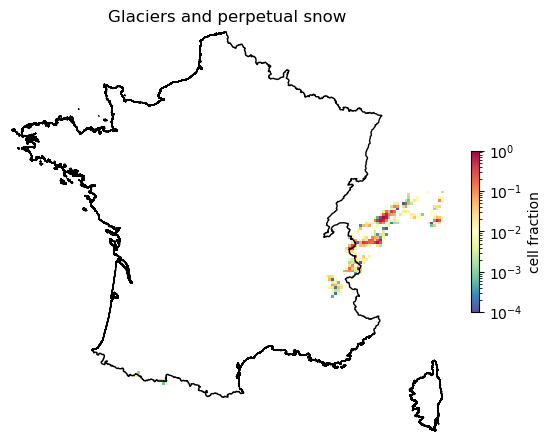

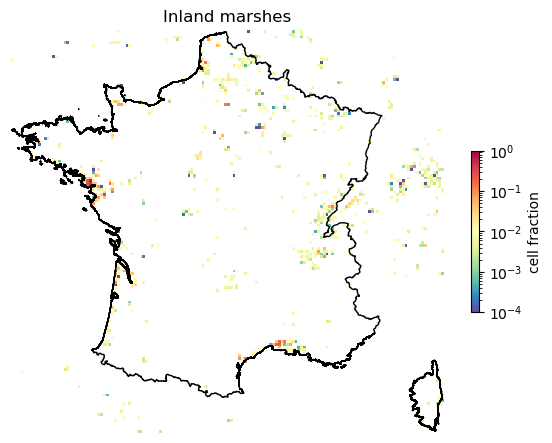

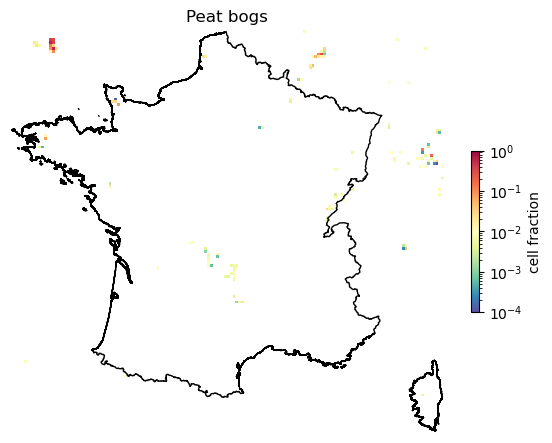

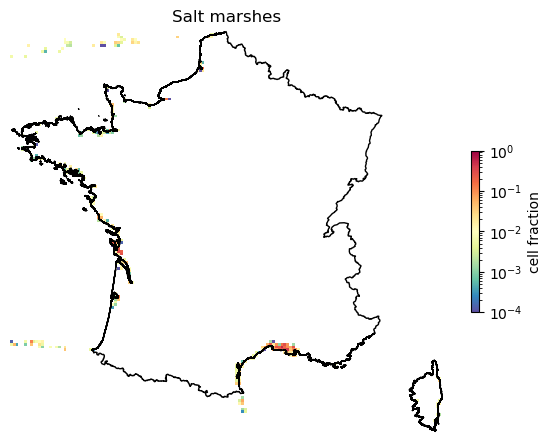

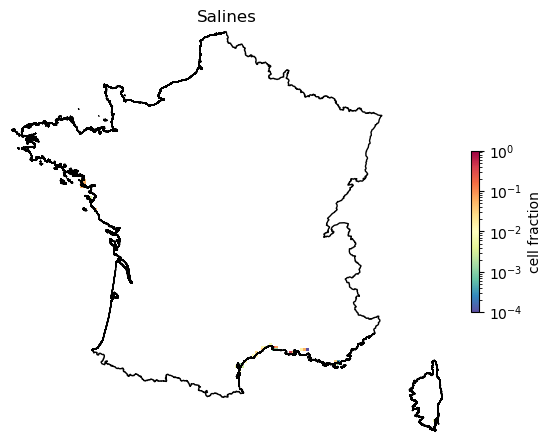

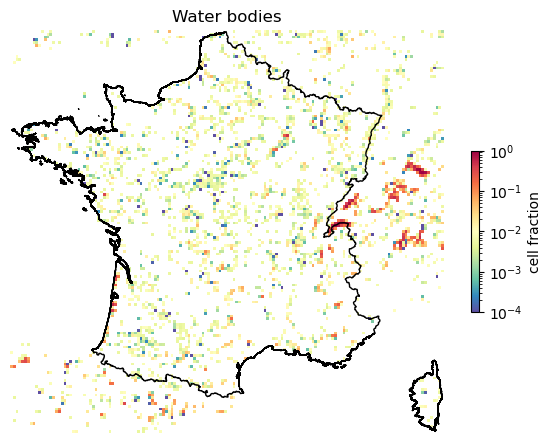

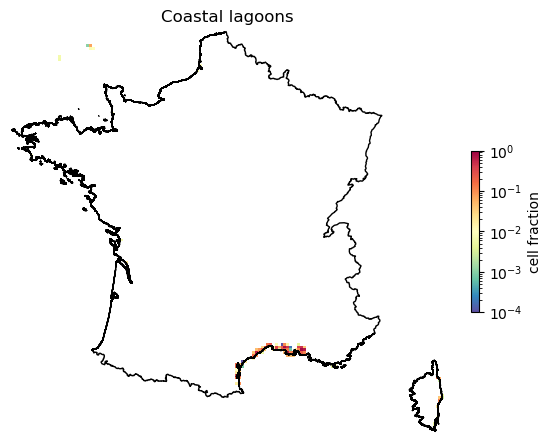

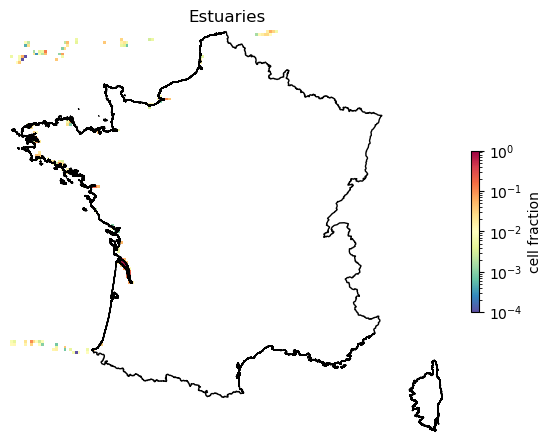

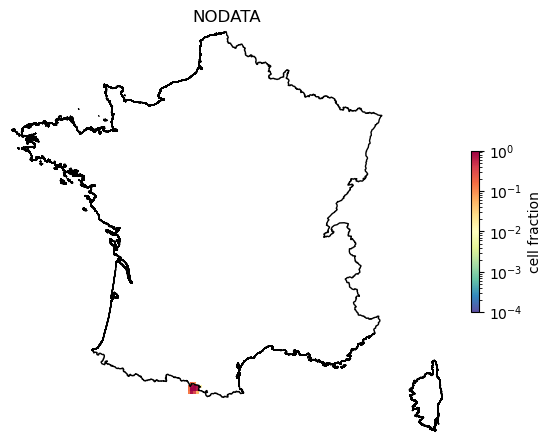

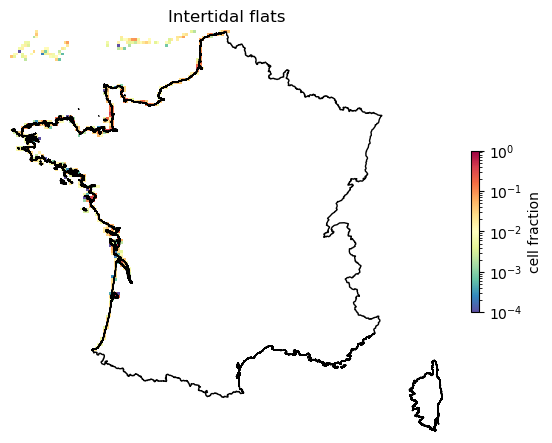

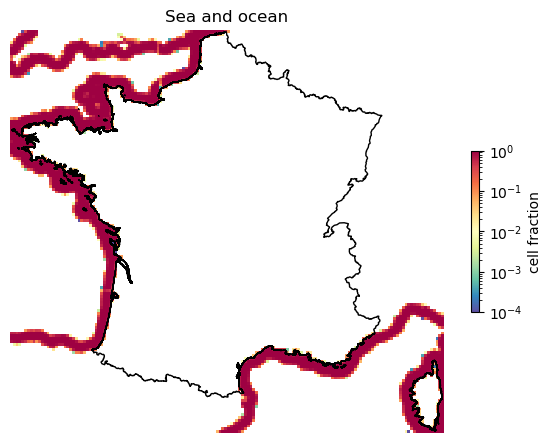

In [10]:
for field in ds.data_vars:
    plt.figure(figsize=(7, 7))
    plt.pcolormesh(x, y, ds[field].values, cmap='Spectral_r', norm=LogNorm(vmin=1e-4, vmax=1e0))
    plt.colorbar(shrink=0.3, label='cell fraction')
    france.plot(ax=plt.gca(), fc='none')
    plt.title(field)
    plt.gca().axis('off')
    plt.show()